# Modelos de Grafos Probabilisticos

siguientes tareas.

· Realizar la tarea de clasificación sobre la variable banking_crisis sin utilizar la variable 
systemic_crisis. No se evaluará sobre la precisión del modelo ya que es una dataset desbalanceado. 
Se evaluará sobre las explicaciones e interpretación de los resultados, arquitectura y construcción 
del modelo.

· Realizar inferencias dadas las evidencias que consideréis para extraer información y explicar los 
resultados obtenidos.

In [1]:
pip install pgmpy

     |████████████████████████████████| 327kB 12.0MB/s 


In [2]:
import pandas as pd
import numpy as np
from pgmpy.estimators import HillClimbSearch, BicScore, BayesianEstimator
import networkx as nx
import pylab as plt
from pgmpy.models import BayesianModel


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
#Leemos el dataset
data=pd.read_csv('C:\\Users\\ignac\\OneDrive\\Escritorio\\BME\\Master\\CLASES\\Modulo 4\\Lenguage Natural\\Practica\\african_crises.csv')

In [4]:
#Mostramos el inicio del dataset
data.head()

,case,cc3,country,year,systemic_crisis,exch_usd,domestic_debt_in_default,sovereign_external_debt_default,gdp_weighted_default,inflation_annual_cpi,independence,currency_crises,inflation_crises,banking_crisis
0,1,DZA,Algeria,1870,1,0.052264,0,0,0.0,3.441456,0,0,0,crisis
1,1,DZA,Algeria,1871,0,0.052798,0,0,0.0,14.149140,0,0,0,no_crisis
2,1,DZA,Algeria,1872,0,0.052274,0,0,0.0,-3.718593,0,0,0,no_crisis
3,1,DZA,Algeria,1873,0,0.051680,0,0,0.0,11.203897,0,0,0,no_crisis
4,1,DZA,Algeria,1874,0,0.051308,0,0,0.0,-3.848561,0,0,0,no_crisis


In [5]:
data.describe()

,case,year,systemic_crisis,exch_usd,domestic_debt_in_default,sovereign_external_debt_default,gdp_weighted_default,inflation_annual_cpi,independence,currency_crises,inflation_crises
count,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1.059000e+03,1059.000000,1059.000000,1059.000000
mean,35.613787,1967.767705,0.077432,43.140831,0.039660,0.152975,0.006402,2.084889e+04,0.776204,0.132200,0.129367
std,23.692402,33.530632,0.267401,111.475380,0.195251,0.360133,0.043572,6.757274e+05,0.416984,0.349847,0.335765
min,1.000000,1860.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.850214e+01,0.000000,0.000000,0.000000
25%,15.000000,1951.000000,0.000000,0.195350,0.000000,0.000000,0.000000,2.086162e+00,1.000000,0.000000,0.000000
50%,38.000000,1973.000000,0.000000,0.868400,0.000000,0.000000,0.000000,5.762330e+00,1.000000,0.000000,0.000000
75%,56.000000,1994.000000,0.000000,8.462750,0.000000,0.000000,0.000000,1.164405e+01,1.000000,0.000000,0.000000
max,70.000000,2014.000000,1.000000,744.306139,1.000000,1.000000,0.400000,2.198970e+07,1.000000,2.000000,1.000000


In [6]:
#Observamos los valores unicos de la variable objetivo y la codificamos numericamente
np.unique(data.banking_crisis)
data.banking_crisis[data.banking_crisis=='crisis']=1
data.banking_crisis[data.banking_crisis=='no_crisis']=0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [7]:
#Determinamos un nuevo dataset del que se eliminan los elementos que creemos que no aportan mucha informacion para que el posterior procesado sea mas rapido
dataclean = data*1
dataclean = dataclean.drop(['systemic_crisis','cc3','country'], 1)
dataclean.head()

,case,year,exch_usd,domestic_debt_in_default,sovereign_external_debt_default,gdp_weighted_default,inflation_annual_cpi,independence,currency_crises,inflation_crises,banking_crisis
0,1,1870,0.052264,0,0,0.0,3.441456,0,0,0,1
1,1,1871,0.052798,0,0,0.0,14.149140,0,0,0,0
2,1,1872,0.052274,0,0,0.0,-3.718593,0,0,0,0
3,1,1873,0.051680,0,0,0.0,11.203897,0,0,0,0
4,1,1874,0.051308,0,0,0.0,-3.848561,0,0,0,0


In [8]:
#para las variables que pueden tomar un gran numero de valores distintos las transformamos en rangos y creamos la particion train test
data1 = dataclean.copy()

for i in ["year","exch_usd","inflation_annual_cpi"]:
  data1[i]=pd.cut(data1[i],5)

data1 = data1.iloc[:-200,:].reset_index(drop=True)
datatest = data1.iloc[-200:,:].reset_index(drop=True)

In [9]:
data1.head()

,case,year,exch_usd,domestic_debt_in_default,sovereign_external_debt_default,gdp_weighted_default,inflation_annual_cpi,independence,currency_crises,inflation_crises,banking_crisis
0,1,"(1859.846, 1890.8]","(-0.744, 148.861]",0,0,0.0,"(-22018.226, 4397916.242]",0,0,0,1
1,1,"(1859.846, 1890.8]","(-0.744, 148.861]",0,0,0.0,"(-22018.226, 4397916.242]",0,0,0,0
2,1,"(1859.846, 1890.8]","(-0.744, 148.861]",0,0,0.0,"(-22018.226, 4397916.242]",0,0,0,0
3,1,"(1859.846, 1890.8]","(-0.744, 148.861]",0,0,0.0,"(-22018.226, 4397916.242]",0,0,0,0
4,1,"(1859.846, 1890.8]","(-0.744, 148.861]",0,0,0.0,"(-22018.226, 4397916.242]",0,0,0,0


In [10]:
#Definimos el metodo de estimacion de la estructura
est = HillClimbSearch(data1, scoring_method=BicScore(data1))

In [11]:
#Estimamos la estructura y obtenemos el mejor modelo
best_model = est.estimate()

  0%|          | 24/1000000 [00:07<82:22:30,  3.37it/s] 


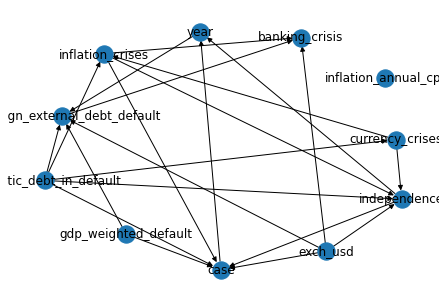

In [12]:
#ploteamos la estructura obtenida
nx.draw(best_model, with_labels=True)
plt.show()

In [13]:
#Escogemos el mejor modelo, definimos los ejes y las variables y lo ajustamos a nuestros datos
best_model.edges()
G = BayesianModel()
G.add_nodes_from(sorted(best_model.nodes()))
G.add_edges_from(best_model.edges())
G.fit(data1)

In [14]:
#Realizamos las predicciones 
pred = G.predict(datatest.drop('banking_crisis',axis=1))
pred["label"] = datatest['banking_crisis'].values

100%|██████████| 37/37 [00:12<00:00,  3.00it/s]


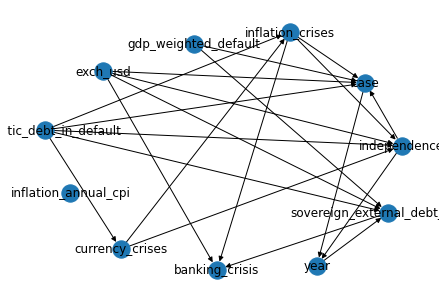

In [15]:
#Ploteamos el modelo
nx.draw(G, with_labels=True)

In [16]:
#Calculamos el error del modelo estimado
(pred["banking_crisis"]-pred["label"]).abs().sum()/pred.shape[0]

0.07

Observamos que tenemos un 0.07 de error y que las variables de la que depende directamente banking crisis son exch usd, inflation crisis y sovereign external debt.

Ahora realizaremos las inferencias sobre el modelo realizado

In [19]:
from pgmpy.inference import VariableElimination
#Definimos el modelo de inferencia
model_infer = VariableElimination(G)

# Inferencia sin ninguna evidencia, en este caso sobre banking crisis y obtenemos  un 92% de 0 y 8% de que si
results = model_infer.query(['banking_crisis'])
results.values

# Inferencia sin ninguna evidencia, en este caso sobre currency_crises y obtenemos  un 89% del primer tramo, 10% del segubndo y el resto del tercero
results1 = model_infer.query(['currency_crises'])
results1.values

Eliminating: domestic_debt_in_default: 100%|██████████| 10/10 [00:00<00:00, 53.52it/s]


array([0.89057043, 0.10477299, 0.00465658])

In [ ]:
# Inferencia dadas varias observaciones, en este apartado podemos introducir los datos que tengamos para realizar inferencias.
results = model_infer.query(['banking_crisis'], evidence={'domestic_debt_in_default': 1, 'year': 2, 'independence': 1, 'currency_crises': 1})
print(results.values)

/usr/local/lib/python3.6/dist-packages/pgmpy/factors/discrete/DiscreteFactor.py:519: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  "Found unknown state name. Trying to switch to using all state names as state numbers"
Eliminating: gdp_weighted_default: 100%|██████████| 6/6 [00:00<00:00, 138.83it/s]

[0.93395353 0.0482819  0.01776457]
